# Traffic Light Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import array_to_img, img_to_array
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13301794587058809573
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7749215847
locality {
  bus_id: 1
}
incarnation: 1853996386052365445
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
]


## CNN

In [3]:
img_width, img_height = 150, 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

In [4]:
K.image_data_format()

'channels_last'

### Train Model

In [5]:
batch_size = 16
epochs = 100

In [6]:
train_datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory='data/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 11195 images belonging to 4 classes.


In [8]:
nb_class = train_generator.num_class
classes = train_generator.class_indices
nb_train_samples = train_generator.samples

In [9]:
nb_train_samples

11195

In [10]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [11]:
%%time

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs)

Epoch 1/100
699/699 [==============================] - 273s - loss: 1.0723 - acc: 0.5249   
Epoch 2/100
699/699 [==============================] - 126s - loss: 0.7205 - acc: 0.7015   
Epoch 3/100
699/699 [==============================] - 126s - loss: 0.5330 - acc: 0.7747   
Epoch 4/100
699/699 [==============================] - 126s - loss: 0.4312 - acc: 0.8199   - ET
Epoch 5/100
699/699 [==============================] - 126s - loss: 0.3599 - acc: 0.8522   
Epoch 6/100
699/699 [==============================] - 126s - loss: 0.3063 - acc: 0.8809   
Epoch 7/100
699/699 [==============================] - 127s - loss: 0.2700 - acc: 0.8950   
Epoch 8/100
699/699 [==============================] - 127s - loss: 0.2402 - acc: 0.9062   
Epoch 9/100
699/699 [==============================] - 127s - loss: 0.2081 - acc: 0.9223   
Epoch 10/100
699/699 [==============================] - 127s - loss: 0.1968 - acc: 0.9261   
Epoch 11/100
699/699 [==============================] - 126s - loss: 0.1825

699/699 [==============================] - 128s - loss: 0.0523 - acc: 0.9827   
Epoch 89/100
699/699 [==============================] - 126s - loss: 0.0422 - acc: 0.9834   
Epoch 90/100
699/699 [==============================] - 126s - loss: 0.0607 - acc: 0.9823   
Epoch 91/100
699/699 [==============================] - 127s - loss: 0.0667 - acc: 0.9799   
Epoch 92/100
699/699 [==============================] - 126s - loss: 0.0668 - acc: 0.9802   
Epoch 93/100
699/699 [==============================] - 126s - loss: 0.0479 - acc: 0.9845   
Epoch 94/100
699/699 [==============================] - 127s - loss: 0.0590 - acc: 0.9814   
Epoch 95/100
699/699 [==============================] - 126s - loss: 0.0575 - acc: 0.9806   
Epoch 96/100
699/699 [==============================] - 126s - loss: 0.0449 - acc: 0.9837   
Epoch 97/100
699/699 [==============================] - 126s - loss: 0.0526 - acc: 0.9816   
Epoch 98/100
699/699 [==============================] - 129s - loss: 0.0636 - acc: 

### Save Model

In [12]:
model_name = 'model_keras_v2.0.8_%d_%d_%d_%d' % (nb_train_samples, batch_size, 
                                              epochs, int(time() * 1e6))
model_name

'model_keras_v2.0.8_11195_16_100_1508741543103608'

In [13]:
model.save_weights(model_name + '.h5') 

In [14]:
model_json = model.to_json()

In [15]:
with open(model_name + '.json', "w") as json_file:
    json_file.write(model_json)

### Test Model

In [16]:
test_datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255)

test_generator = train_datagen.flow_from_directory(
    'data/loop_with_traffic_light/training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1151 images belonging to 4 classes.


In [17]:
%%time

i = 0
for images in test_generator:
    print(images[0].shape)
    predictions = model.predict(images[0])
    i += 1
    if i > 0:
        break

(16, 150, 150, 3)
CPU times: user 628 ms, sys: 8 ms, total: 636 ms
Wall time: 912 ms


### Visualize Examples

In [18]:
class_to_idx = train_generator.class_indices
class_to_idx

{'green': 0, 'red': 1, 'unknown': 2, 'yellow': 3}

#### Overlay Color Labels

In [19]:
red = Image.new('RGB', (img_width, 10), (255, 0, 0))
green = Image.new('RGB', (img_width, 10), (0, 255, 0))
yellow = Image.new('RGB', (img_width, 10), (244, 219, 36))
unknown = Image.new('RGB', (img_width, 10), (75, 0, 130))

In [20]:
idx_to_class = {}
idx_to_overlay = {}

In [21]:
for k, v in class_to_idx.items():
    idx_to_class[v] = k
    idx_to_overlay[v] = eval(k)

In [22]:
idx_to_class

{0: 'green', 1: 'red', 2: 'unknown', 3: 'yellow'}

In [23]:
idx_to_overlay

{0: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F9ED4AF6518>,
 1: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F9ED4AF6638>,
 2: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F9ED4AF6758>,
 3: <PIL.Image.Image image mode=RGB size=150x10 at 0x7F9ED4AF65F0>}

#### Sample Images from Several Sources

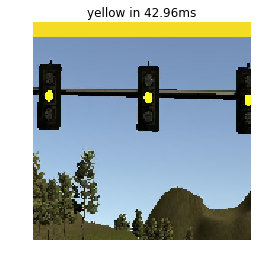

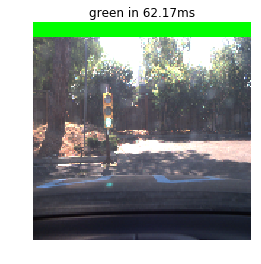

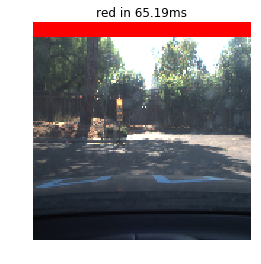

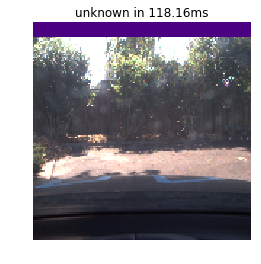

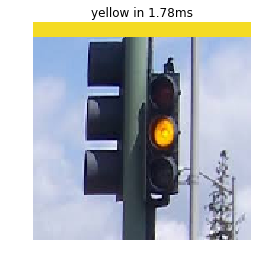

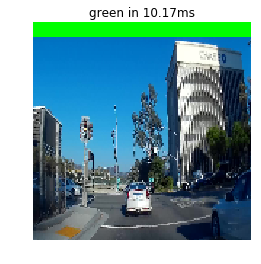

CPU times: user 764 ms, sys: 840 ms, total: 1.6 s
Wall time: 1.37 s


In [24]:
%%time

images = [
    load_img('data/simulator_traffic_light/training/yellow/sim-1506291430325470.jpeg'),
    load_img('data/loop_with_traffic_light/training/green/1503524655778037037.png'),
    load_img('data/just_traffic_light/training/red/1503524771576164202.png'),
    load_img('data/just_traffic_light/training/unknown/1503524776309465909.png'),
    load_img('data/internet/yellow/yellow-internet-0013.jpg'),
    load_img('data/dashcam/green/2017_0929_172227_530-000051.jpg'),
]

for image in images:
    
    # Pipeline start time
    start = time()
    
    # Resize to 150x150
    img = image.resize((img_width, img_height))

    # Normalized numpy array with shape (150, 150, 3)
    x = img_to_array(img, data_format='channels_last') / 255.

    # Numpy array with shape (1, 150, 150, 3)
    x = x.reshape((1,) + x.shape)
    
    prediction = model.predict(x)
    
    pred_idx = np.argmax(prediction[0])
    img.paste(idx_to_overlay[pred_idx], (0, 0))
    
    # Pipeline end prediction time
    end = time()
    
    plt.imshow(img)
    plt.title('%s in %4.2fms' % (idx_to_class[pred_idx], (end - start) * 1000))
    plt.axis('off')
    plt.show()

## Load Model

In [2]:
import tensorflow as tf

from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [4]:
fname = './models/model_keras_v2.0.8_11195_16_100_1508741543103608'
file = open(fname + '.json', 'r')
json_string = file.read()
file.close()
model = model_from_json(json_string)
model.load_weights(fname + '.h5')

In [5]:
# Due to bug in Keras
# https://github.com/fchollet/keras/issues/2397

model._make_predict_function()
graph = tf.get_default_graph()

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

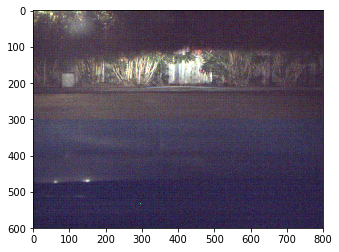

In [33]:
img_width, img_height = 150, 150
image = load_img('792999/1508465988-235507479.png')
plt.imshow(image)
image = image.resize((img_width, img_height))
image = img_to_array(image, data_format='channels_last') / 255.
image = image.reshape((1,) + image.shape)

In [31]:
model.predict_classes(image)

1/1 [==============================] - 4s


array([2])

## Generate Videos from Rosbag Images

In [25]:
from glob import glob

In [26]:
rosbag = '792999'

In [27]:
files = glob(rosbag + '/*')
files.sort()

In [28]:
class_to_idx = {'green': 0, 'red': 1, 'unknown': 2, 'yellow': 3}
idx_to_class = {}
idx_to_overlay = {}

In [29]:
img_width, img_height = 150, 150
uc_width = 1368 / 4
uc_height = 1096 / 4
red = Image.new('RGB', (uc_width, 20), (255, 0, 0))
green = Image.new('RGB', (uc_width, 20), (0, 255, 0))
yellow = Image.new('RGB', (uc_width, 20), (244, 219, 36))
unknown = Image.new('RGB', (uc_width, 20), (75, 0, 130))
for k, v in class_to_idx.items():
    idx_to_class[v] = k
    idx_to_overlay[v] = eval(k)

In [30]:
times = []
for i, f in enumerate(files):
    image = load_img(f)
    # Pipeline start time
    start = time()
    
    # Resize to 150x150
    img = image.resize((img_width, img_height))

    # Normalized numpy array with shape (150, 150, 3)
    x = img_to_array(img, data_format='channels_last') / 255.

    # Numpy array with shape (1, 150, 150, 3)
    x = x.reshape((1,) + x.shape)
    
    prediction = model.predict(x)
    
    pred_idx = np.argmax(prediction[0])
    
    # Pipeline end prediction time
    end = time()
    
    image = image.resize((uc_width, uc_height))
    image.paste(idx_to_overlay[pred_idx], (0, 0))
    image.save('videos/' + f)
    
    times.append((end - start) * 1000)

In [31]:
1.0 * sum(times)/len(times)

12.25632033675945

In [32]:
!ffmpeg -pattern_type glob -i 'videos/{rosbag}/*.png' {rosbag}-night.mp4

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

## Calvenn Classifier

In [48]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7, allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))   

saver = tf.train.import_meta_graph('./models/tl_cnn_weight-1000.meta')
saver.restore(sess,tf.train.latest_checkpoint('./models/'))
graph = tf.get_default_graph()
    
tf_data = graph.get_tensor_by_name("image_input:0")
tf_train = graph.get_tensor_by_name("train_input:0")
tf_label = graph.get_tensor_by_name("labels_input:0")    
sm = graph.get_tensor_by_name("output:0")

INFO:tensorflow:Restoring parameters from ./models/tl_cnn_weight-1000


In [49]:
def augment(raw,boolean, color, dummy):
    xx, yy = np.meshgrid(np.arange(dummy.shape[3]),np.arange(dummy.shape[2]))

    x = (xx[boolean])
    y = (yy[boolean])

    for i,j in zip(x,y):
        cv2.rectangle(raw, (i * 8, j * 8), (i * 8 + 64,j * 8 + 64), color, 2)

def run(testdata):
    
    testdata = cv2.resize(testdata, (400, 300))
    testdata = cv2.cvtColor(testdata, cv2.COLOR_BGR2RGB)

    img = sess.run([sm], feed_dict={tf_data: testdata.reshape([1, 300, 400, 3]), 
                                    tf_train: False})
    
    threshold = 0.9999
        
    img = np.array(img)
                
    augment(testdata,img[0,0,:,:,1] > threshold,(255, 0, 0), img)
    augment(testdata,img[0,0,:,:,2] > threshold,(0, 255, 0), img)
    augment(testdata,img[0,0,:,:,3] > threshold,(255, 255, 0), img)
    
    testdata = cv2.cvtColor(testdata, cv2.COLOR_BGR2RGB)

    return img

In [52]:
import cv2

In [58]:
times = []
for i, f in enumerate(files):
    image = cv2.imread(f)
    
    # Pipeline start time
    start = time()
    
    loc = run(image)
    threshold = 0.9999
    r = np.sum(loc[0,0,:,:,1] > threshold)
    g = np.sum(loc[0,0,:,:,2] > threshold)
    y = np.sum(loc[0,0,:,:,3] > threshold)

    result = 2  # TrafficLight.UNKNOWN
    if (r + g + y) > 20:
        if(r >= g and r >= y):
            result = 1  # TrafficLight.RED
        elif(g > y and g > 15):
            result = 0  # TrafficLight.GREEN
        elif(y > 10):
            result = 3  # TrafficLight.YELLOW
    else:
            result = 2  # TrafficLight.UNKNOWN

    # Pipeline end prediction time
    end = time()

    image = cv2.resize(image, (uc_width, uc_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image.paste(idx_to_overlay[result], (0, 0))
    image.save('videos/calvenn/' + f)
    
    times.append((end - start) * 1000)

In [59]:
1.0 * sum(times)/len(times)

2.76803308861966

In [60]:
!ffmpeg -pattern_type glob -i 'videos/calvenn/{rosbag}/*.png' {rosbag}-calvenn.mp4

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e